# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.702248,True,5.978465
1,0.242950,True,5.179916
2,-0.116326,False,-0.356853
3,1.645223,True,8.752096
4,-0.723724,False,-2.508062
...,...,...,...
995,-0.889849,False,-1.559411
996,1.151900,True,5.837588
997,0.445196,True,6.059408
998,-1.054015,True,1.756732


<AxesSubplot:xlabel='v0'>

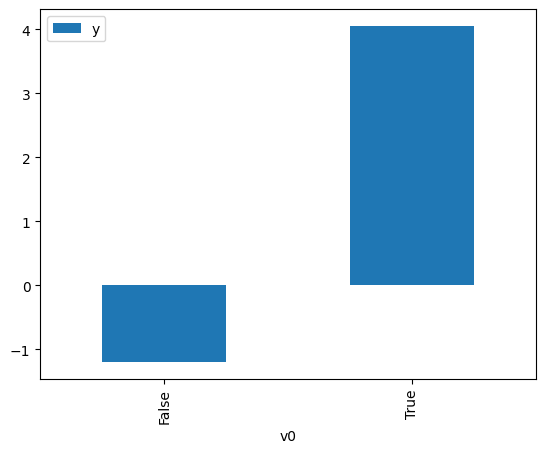

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

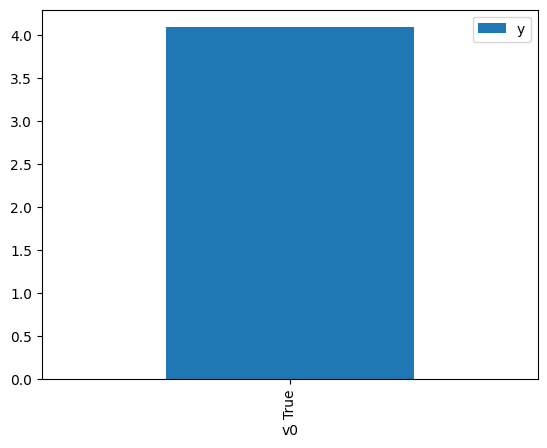

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.733220,False,-1.790374,0.708815,1.410805
1,-0.172106,False,-1.911025,0.549149,1.820999
2,-0.209882,False,-2.585859,0.560662,1.783607
3,0.153014,False,0.795389,0.449186,2.226247
4,-0.511758,False,-1.381405,0.649390,1.539907
...,...,...,...,...,...
995,-0.388414,False,0.023920,0.613999,1.628667
996,-0.441582,False,-1.326555,0.629428,1.588745
997,0.484657,False,1.561905,0.351330,2.846330
998,-1.015037,False,-1.370874,0.775110,1.290139


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.376530,True,2.719697,0.389482,2.567510
1,1.799778,True,8.977890,0.903439,1.106882
2,-0.622399,True,4.438742,0.320193,3.123119
3,-1.497676,True,1.796665,0.137886,7.252373
4,-0.326504,True,2.444747,0.404257,2.473673
...,...,...,...,...,...
995,-0.065326,True,5.570035,0.483639,2.067659
996,-0.696123,True,1.774305,0.300722,3.325327
997,-1.039387,True,1.776274,0.219696,4.551753
998,0.488424,True,4.557893,0.649729,1.539103


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              8206.
Date:                Mon, 22 Aug 2022   Prob (F-statistic):                        0.00
Time:                        06:28:52   Log-Likelihood:                         -1412.4
No. Observations:                1000   AIC:                                      2829.
Df Residuals:                     998   BIC:                                      2839.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1886      0.029     76.776      0.000       2.133       2.245
x2             4.9412      0.050     97.961      0.000       4.842       5.040
==============================================================================
Omnibus:                        6.349   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.342
Skew:                           0.164   Prob(JB):                       0.0420
Kurtosis:                       3.213   Cond. No.                         1.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""